In [6]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDIMScheduler
from peft import PeftModel
import torch

In [7]:
model_id = "sd-legacy/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
pipe = pipe.to("cpu")

# Проверяем, что все компоненты модели в FP16 и на cuda
assert pipe.unet.dtype == torch.float32# and pipe.unet.device.type =='cuda'
assert pipe.vae.dtype == torch.float32# and pipe.vae.device.type == 'cuda'
assert pipe.text_encoder.dtype == torch.float32# and pipe.text_encoder.device.type == 'cuda'

# Заменяем дефолтный сэмплер на DDIM
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")
#pipe.scheduler.timesteps = pipe.scheduler.timesteps.cuda()
#pipe.scheduler.alphas_cumprod = pipe.scheduler.alphas_cumprod.cuda()

unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
unet.to('cpu')

assert unet.dtype == torch.float32

Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


In [8]:
cm_unet = PeftModel.from_pretrained(
    unet,
    "jmpleo/cv-week-2024",
    subfolder='multi-cd',
    adapter_name="multi-cd",
)

100%|██████████| 4/4 [01:54<00:00, 28.58s/it]


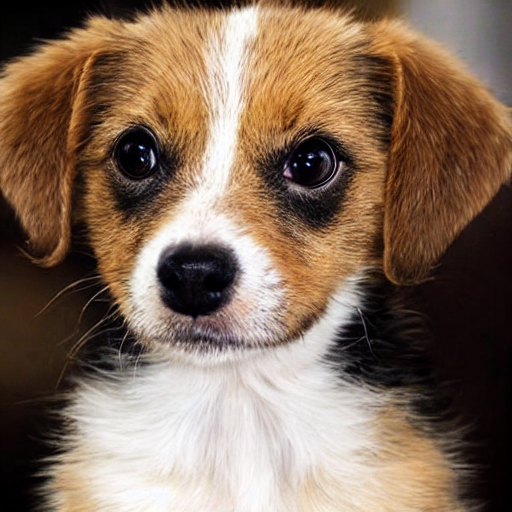

In [11]:
pipe.unet = cm_unet.eval().to(torch.float32)
assert cm_unet.active_adapter == 'multi-cd'

generator = torch.Generator(device="cpu").manual_seed(1)

images = pipe(
    prompt="A sad puppy with large eyes",
    num_inference_steps=4,
    generator=generator,
    num_images_per_prompt=1,
    guidance_scale=1
).images

images[0]